<center>Progetto realizzato da Elena Curti (matr. 185431)

# Cambiamenti climatici
</center>

## Introduzione
Per “cambiamenti climatici” si intendono i cambiamenti a lungo termine delle temperature e dei modelli meteorologici. Questi cambiamenti possono avvenire in maniera naturale, ad esempio tramite variazioni del ciclo solare. Tuttavia, a partire dal 19° secolo, le attività umane sono state il fattore principale all’origine dei cambiamenti climatici, imputabili essenzialmente alla combustione di combustibili fossili come il carbone, il petrolio e il gas. Per questo motivo nel 1992 è stata data dalle Nazioni unite la seguente definizione di “cambiamento climatico”: qualsiasi alterazione dell’atmosfera globale che sia riconducibile all’azione umana in modo diretto o indiretto. 

<center><i>“<b>Climate change</b> means a change in climate which is attributed directly or indirectly to human activity that alters the composition <br> of the global atmosphere and which is in addition to natural climate variability observed over comparable periods of time.” </I> <br>
- United nations framework convention on climate change, 1992 </center>

### Cause
Generare energia elettrica e calore bruciando combustibili fossili provoca una grossa fetta delle emissioni globali. La maggior parte dell’elettricità viene ancora generata bruciando carbone, petrolio o gas, che producono anidride carbonica e ossido di azoto, dei potenti gas serra capaci di avvolgere la Terra intrappolando il calore del sole. A livello globale, si valuta che solamente un quarto dell’energia elettrica provenga dal vento, dal sole e da altre fonti rinnovabili le quali, al contrario dei combustibili fossili, emettono nell’aria una quantità minima o nulla di gas serra o di sostanze inquinanti.
<br> Altre cause dei cambiamenti climatici sono: produzione di beni di consumo (ad esempio nell’industria elettronica e tessile), disboscamento, utilizzo di automobili, camion, navi e aerei. 

### Effetti
- Una delle conseguenze più evidente è l'aumento delle temperature. Aumentando la concentrazione di gas serra, infatti, aumenta anche la temperatura superficiale globale. A partire dagli anni Ottanta ogni decennio ha visto un incremento delle temperature fino al periodo 2011-2020, il più caldo mai registrato. In quasi tutte le aree del pianeta assistiamo a giorni più afosi e ondate di calore. Le temperature più alte favoriscono l’insorgenza di patologie da calore e rendono più difficile lavorare all’aperto, mentre gli incendi si verificano più facilmente e si propagano più rapidamente.
- Riscaldamento e Innalzamento degli oceani. Le acque oceaniche assorbono la maggior parte del calore derivante dal riscaldamento atmosferico globale. Il ritmo del loro riscaldamento è fortemente aumentato negli ultimi due decenni, un fenomeno riscontrato a tutte le profondità. Aumentando il calore aumenta anche il volume delle acque con conseguente innalzamento dei livelli che, accompagnati dal progressivo scioglimento delle calotte glaciali, determinano una reale minaccia per le comunità costiere e insulari. Ad aggravare la situazione concorre anche l’assorbimento della anidride carbonica sottratta all’atmosfera da parte delle acque oceaniche con conseguente acidificazione delle stesse e reale pericolo per la vita marina e le barriere coralline.
- Tempeste più violente
- Aumento della siccità
- Perdita di spcie
- Mancanza di cibo
- Maggiori rischi per la salute
- Povertà e migrazioni

## Requisiti:

In [32]:
# %pip install pandas matplotlib seaborn scipy sklearn scikit-learn 

## 1. Raccolta di dati
I dati raccolti si trovano nella cartella [original](applicazione/data/original/). 

- I file contenenti i dati relativi alle temperature ([temperatures.dat](applicazione/data/original/temperatures.dat)) e alle stazioni geografiche ([stations.inv](applicazione/data/original/stations.inv)) sono stati trovati sul sito [National Centers for Environmental Information](https://www.ncei.noaa.gov/). Sono scaricabili al seguente link: https://www.ncei.noaa.gov/pub/data/ghcn/v4/ghcnm.tavg.latest.qcf.tar.gz <br>

- I file contenenti informazioni sui Paesi sono stati trovati su due repository di github: 
    - [fips_to_iso_country_codes.csv](applicazione/data/original/fips_to_iso_country_codes.csv) trovato al seguente link: https://github.com/mysociety/gaze/blob/master/data/fips-10-4-to-iso-country-codes.csv
    - [countries_info.csv](applicazione/data/original/countries_info.csv) trovato al seguente link https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv <br><br>

- Il file contenente informazioni sui livelli del mare ([sea_levels.csv](applicazione/data/original/sea_levels.csv)) è stato trovato su Kaggle al seguente link https://www.kaggle.com/datasets/kkhandekar/global-sea-level-1993-2021<br>

- Il file contenente informazioni sui livelli di CO2 [co2_levels.csv](applicazione/data/original/co2_levels.csv) è stato trovato su Kaggle al link https://www.kaggle.com/datasets/programmerrdai/co2-levels-globally-from-fossil-fuels

## 2. Elaborazione dei dati

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

pd.options.display.max_rows = None
pd.options.display.max_columns = None
# pd.set_option('display.', None)

DATA_FOLDER = "applicazione" + os.path.sep + "data" + os.path.sep
DATA_ORIGINAL_FOLDER = DATA_FOLDER + "original"+ os.path.sep
DATA_MODIFIED_FOLDER = DATA_FOLDER + "modified"+ os.path.sep

### Stazioni e temperature
I file [stations.inv](applicazione/data/original/stations.inv) e [temperatures.dat](applicazione/data/original/temperatures.dat) trovati su internet sono Fixed Width Text File. Ho deciso di modificarli e convertirli in file CSV ([stations_created.csv](applicazione/data/modified/stations_created.csv), [tempetatures_created.csv](applicazione/data/modified/tempetatures_created.csv)). In questo modo creo due file con i dati pronti per essere letti in futuro. 

#### Stazioni
Il file creato [stations_created.csv](applicazione/data/modified/stations_created.csv) ha la seguente struttura:
|Campo| Significato|
|:-|:-|
|station_id| Codice identificativo della stazione. I primi due caratteri sono il codice FIPS del Paese|
|latitude| Latitudine della stazione in gradi decimali|
|longitude| Longitudine della stazione in gradi decimali|
|station_elev| Altitudine della stazione in metri |
|station_name| Nome della stazione|
|fips| Codice FIPS del Paese|

Rispetto al file trovato su internet:
- Ho aggiunto il campo "fips" selezionando i primi due caratteri di station_id. In questo modo semplifico il merge con le informazioni sui Paesi. 
- Ho sostituito il valore 9999 col valore "nullo" di Pandas nella colonna "station_elev", perchè esso rappresenta un dato mancante. 

In [34]:
import calendar

# File con le stazioni
FILE_ORIGINALE_STATIONS = DATA_ORIGINAL_FOLDER + "stations.inv"
FILE_CSV_STATIONS = DATA_MODIFIED_FOLDER + "stations_created.csv"
HEADERS_STATIONS = ["station_id","latitude","longitude","station_elev","station_name"]

if not os.path.exists(FILE_CSV_STATIONS):
    print("Creo file csv partendo da",FILE_ORIGINALE_STATIONS,"...")
    
    # Leggo il file
    df = pd.read_fwf(FILE_ORIGINALE_STATIONS,widths=[11,9,10,7,31], header=None, names=HEADERS_STATIONS)
    
    # Aggiungo il campo fips
    df['fips'] = df["station_id"].apply(lambda x : x[0:2])
    HEADERS_STATIONS += ["fips"]
    
    # Trasformo i valori -999.0 di station_elev in Nan
    df["station_elev"] = df["station_elev"].apply(lambda x: pd.NA if x == 9999 else x)

    # Converto in formato CSV
    df.to_csv(FILE_CSV_STATIONS, index=False)

# Leggo il nuovo file
df_stations = pd.read_csv(FILE_CSV_STATIONS)

#### Temperature
Il file creato [tempetatures_created.csv](applicazione/data/modified/stations_created.csv) ha la seguente struttura:
|Campo| Significato|
|:-|:-|
|station_id| Codice identificativo della stazione. I primi due caratteri sono il codice FIPS del Paese|
|year| Anno in cui sono state misurate le temperature|
|month_value| Valore della temperatura del mese "month" in gradi Celsius |
|temp_media| Temperatura media annuale (gradi °C) |

Rispetto al file trovato su internet:
- Ho eliminato alcune colonne non necessarie
- Ho convertito i valori di month_value in float. 
- Ho eliminato i record con valori mancanti
- Ho aggiunto il campo temp_media

In [35]:
# File con le temperature
FILE_ORIGINALE_TEMPERATURES = DATA_ORIGINAL_FOLDER + "temperatures.dat"
FILE_CSV_TEMPERATURES = DATA_MODIFIED_FOLDER + "temperatures_created.csv"

# Creo due liste: una con le lunghezze dei campi e una con i nomi delle colonne
list_width= [11,4,4] + [j for i in [[5,1,1,1] for _ in range(12)] for j in i] 
HEADERS_TEMPERATURES = ["station_id", "year", "DEL_ME"]
for i in range(1,13):
    month_name = calendar.month_name[i]
    HEADERS_TEMPERATURES += [month_name+"_value","DEL_ME"+str(i)+"a","DEL_ME"+str(i)+"d","DEL_ME"+str(i)+"b"]

if not os.path.exists(FILE_CSV_TEMPERATURES):
    print("Creo file csv partendo da",FILE_ORIGINALE_TEMPERATURES,"...")
    
    # Leggo il file
    df = pd.read_fwf(FILE_ORIGINALE_TEMPERATURES, widths=list_width,header=None, names=HEADERS_TEMPERATURES)
    
    # Elimino le colonne non necessarie
    HEADERS_TEMPERATURES = [i for i in HEADERS_TEMPERATURES if not i.__contains__("DEL_ME")]
    df = df[HEADERS_TEMPERATURES]

    # Cambio i valori -9999 di month_value con NaN. Trasformo anche i valori validi in gradi decimali. 
    for i in range(1,13):
        month_name = calendar.month_name[i]
        df[month_name+"_value"] = df[month_name+"_value"].apply(lambda x: pd.NA if str(x) == "-9999" else x/100)

    # Rimuovo i record con valori nulli
    df = df.dropna()

    # Calcolo la temperatura media
    df["temp_media"] = df[[calendar.month_name[i]+"_value" for i in range(1,13)]].mean(axis=1)    
    df["temp_media"] = df["temp_media"].apply(lambda x: round(x, 2))    

    # Converto in formato CSV
    df.to_csv(FILE_CSV_TEMPERATURES, index=False)

# Leggo il nuovo file
df_temperatures = pd.read_csv(FILE_CSV_TEMPERATURES)


### Paesi
Per quanto riguarda le informazioni sui paesi, ho unito le informazioni dei due file [country_info.csv](applicazione/data/original/countries_info.csv) e [fips_to_iso_country_codes.csv](applicazione/data/original/fips_to_iso_country_codes.csv), ottenendo quindi un DataFrame unico con la seguente  struttura:

|Campo|Significato|
|:-|:-|
|fips| Codice FIPS del paese|
|name_country| Nome del Paese|
|region| Continente di appartenenza|
|sub-region| Zona del continente (nord, sud, est, ovest)|
|region-code| Codice di region|
|sub-region-code| Codice di sub-region|

In [36]:
# File dei paesi
FILE_ORIGINALE_FIPS_TO_ISO = DATA_ORIGINAL_FOLDER + "fips_to_iso_country_codes.csv"
FILE_ORIGINALE_COUNTRY_INFO = DATA_ORIGINAL_FOLDER + "countries_info.csv"

# Leggo i files originali
df_fips_tmp = pd.read_csv(FILE_ORIGINALE_FIPS_TO_ISO)
df_country = pd.read_csv(FILE_ORIGINALE_COUNTRY_INFO)

# Faccio il join sul codice alpha-2
df_country = pd.merge(df_fips_tmp, df_country, how='left',left_on='ISO 3166', right_on='alpha-2')

# Elimino le colonne non necessarie e rinomino le altre
df_country = df_country.drop(['ISO 3166','iso_3166-2', 'alpha-3', 'alpha-2', 'country-code', 'intermediate-region', 'intermediate-region-code'], axis=1)
df_country['name_country'] = df_country.apply(lambda x : str(x['Name'] if pd.isna(x["name"]) else x['name']), axis=1)
df_country = df_country.drop([ 'name', 'Name'], axis=1)
df_country = df_country.rename(columns={"FIPS 10-4":"fips"})

### Livelli del mare
Dal file originale contenente i livelli del mare negli ultimi anni [sea_levels.csv](applicazione/data/original/sea_levels.csv) ho deciso di lasciare i seguenti campi: 

|Campo| Significato|
|:-|:-|
|year| anno (impostato come indice)|
|gmsl_variation| Variazione del livello del mare (Global Mean Sea Level) in mm |

Inoltre, nel file originale c'erano più record per anno. Per semplicità, ho deciso di mantenerne solo uno per ogni anno, che rappresenti la media dei record. 

In [37]:
# Elaborazione del file sea_levels.csv
df_sea = pd.read_csv(DATA_ORIGINAL_FOLDER + "sea_levels.csv")
df_sea = df_sea[["Year", "GMSL_noGIA"]]
df_sea = df_sea.rename(columns={"Year":"year", "GMSL_noGIA": "gmsl_variation"})
df_sea = df_sea.groupby("year").mean()

#### Livelli di C02
Infine, ho letto i dati dal file [co2_levels.csv](applicazione/data/original/co2_levels.csv) e ne ho selezionato il solo campo "Total" memorizzato come "co2_level". 

|Campo| Significato|
|:-|:-|
|year| anno (impostato come indice)|
|co2_level| Emissioni totali di carbonio derivanti dal consumo di combustibili fossili e dalla produzione di cemento (in milioni di tonnellate di C)|


In [38]:
# Elaborazione del file co2_levels.csv
df_co2 = pd.read_csv(DATA_ORIGINAL_FOLDER + "co2_levels.csv")
df_co2 = df_co2[["Year", "Total"]]
df_co2 = df_co2.rename(columns={"Year":"year", "Total": "co2_level"})
df_co2 = df_co2.set_index("year")

## 3. Visualizzazione dei dati

Una volta letti tutti i file CSV si ottengono i seguenti risultati:

In [39]:
# Temperature, stazioni e paesi
df = df_temperatures.merge(df_stations).merge(df_country)
display(df.sample(4))

,station_id,year,January_value,February_value,March_value,April_value,May_value,June_value,July_value,August_value,September_value,October_value,November_value,December_value,temp_media,latitude,longitude,station_elev,station_name,fips,region,sub-region,region-code,sub-region-code,name_country
386921,MX000020039,2000,26.55,27.45,30.30,30.80,30.25,28.65,31.00,30.34,27.85,27.15,27.20,25.25,28.57,16.4670,-95.1000,61.0,IXTEPEC,MX,Americas,Latin America and the Caribbean,19.0,419.0,Mexico
598773,USC00028619,2013,6.77,8.16,16.09,18.27,22.01,28.86,26.60,26.14,24.51,19.45,13.98,9.17,18.33,31.7119,-110.0686,1420.1,TOMBSTONE,US,Americas,Northern America,19.0,21.0,United States of America
380560,MP000061986,1958,28.08,28.01,28.50,27.96,24.53,22.25,24.08,23.84,24.31,24.95,26.26,27.79,25.88,-16.4500,59.6170,4.0,ST_BRANDON_ST_RA,MP,Africa,Sub-Saharan Africa,2.0,202.0,Mauritius
673344,USC00129253,1916,2.81,0.09,5.31,11.41,19.12,21.25,27.17,26.37,20.53,14.31,8.41,0.22,13.08,38.6489,-87.1989,152.4,WASHINGTON_1_W,US,Americas,Northern America,19.0,21.0,United States of America


In [55]:
# Livelli del mare
display(df_sea.head(4))

,gmsl_variation
year,
1993,-34.605405
1994,-30.951081
1995,-28.645946
1996,-26.596389


In [59]:
display(df_co2.tail(4))

,co2_level
year,
2007,8566
2008,8783
2009,8740
2010,9167


### Informazioni e statistiche sui dati

#### Temperature

In [74]:
# Lambda function per sistemare l'output delle statistiche stampate
function_sistema_output = lambda x : x if type(x) == str else ('{:.0f}'.format(x) if pd.isna(x) or int(x) == x else  '{:.2f}'.format(x))

# Stampo le statistiche 
df_describe = df_temperatures.describe(include='all')

# Sistemo l'output
df_describe = df_describe.applymap(function_sistema_output)

display(df_describe)

,station_id,year,January_value,February_value,March_value,April_value,May_value,June_value,July_value,August_value,September_value,October_value,November_value,December_value,temp_media
count,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549,1077549
unique,27769,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,NLM00006260,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,316,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,nan,1969.71,1.17,2.47,6.16,10.70,14.97,18.56,20.68,20.12,16.93,12.15,6.75,2.60,11.10
std,nan,36.30,12.83,12.39,10.61,8.39,6.86,6.31,6.17,6.13,6.49,7.72,9.94,11.89,7.79
min,nan,1702,-61.03,-61,-62.10,-68.60,-70.30,-72.83,-73.80,-75,-71.05,-70.50,-77,-72.79,-57.90
25%,nan,1950,-6.51,-5.30,-0.52,5.53,10.84,14.57,17.02,16.29,12.71,7.42,1.04,-4.38,6.29
50%,nan,1975,-0.13,1.26,5.10,9.81,14.40,18.38,21.05,20.29,16.49,11.37,5.55,1.21,10.26
75%,nan,1998,7.80,9.35,12.46,15.72,19.02,22.91,25.17,24.60,21.48,16.95,12.54,8.78,16.13


Si può quindi vedere che ci sono in totale 27769 stazioni che registrano le temperature. Il primo anno in cui è stata misurata la temperatura è il 1702 e ò'ultimo il 2021. 

#### Livello del mare

In [94]:
df_tmp = df_sea.copy()
df_tmp["year"] = df_tmp.index
df_describe = df_tmp.describe(include="all")
df_describe.applymap(function_sistema_output)

,gmsl_variation,year
count,29,29
mean,5.46,2007
std,26.81,8.51
min,-34.61,1993
25%,-18.43,2000
50%,1.49,2007
75%,24.85,2014
max,50.03,2021


In totale ci sono 29 record che vanno dal 1993 al 2021. 

#### Livelli di CO2

In [95]:
df_tmp = df_co2.copy()
df_tmp["year"] = df_tmp.index
df_describe = df_tmp.describe(include="all")
df_describe.applymap(function_sistema_output)

,co2_level,year
count,260,260
mean,1402.79,1880.50
std,2253.10,75.20
min,3,1751
25%,12.75,1815.75
50%,239.50,1880.50
75%,1385,1945.25
max,9167,2010


In questo file, infine, ci sono 260 record che vanno dal 1751 al 2010.

### Esiste l'effetto serra?

Nel grafico a sinistra si può osservare di quanti gradi (°C) è aumentata la temperatura tra gli anni 1980 e 2000.
In quello a destra tra il 1980 e il 2020.


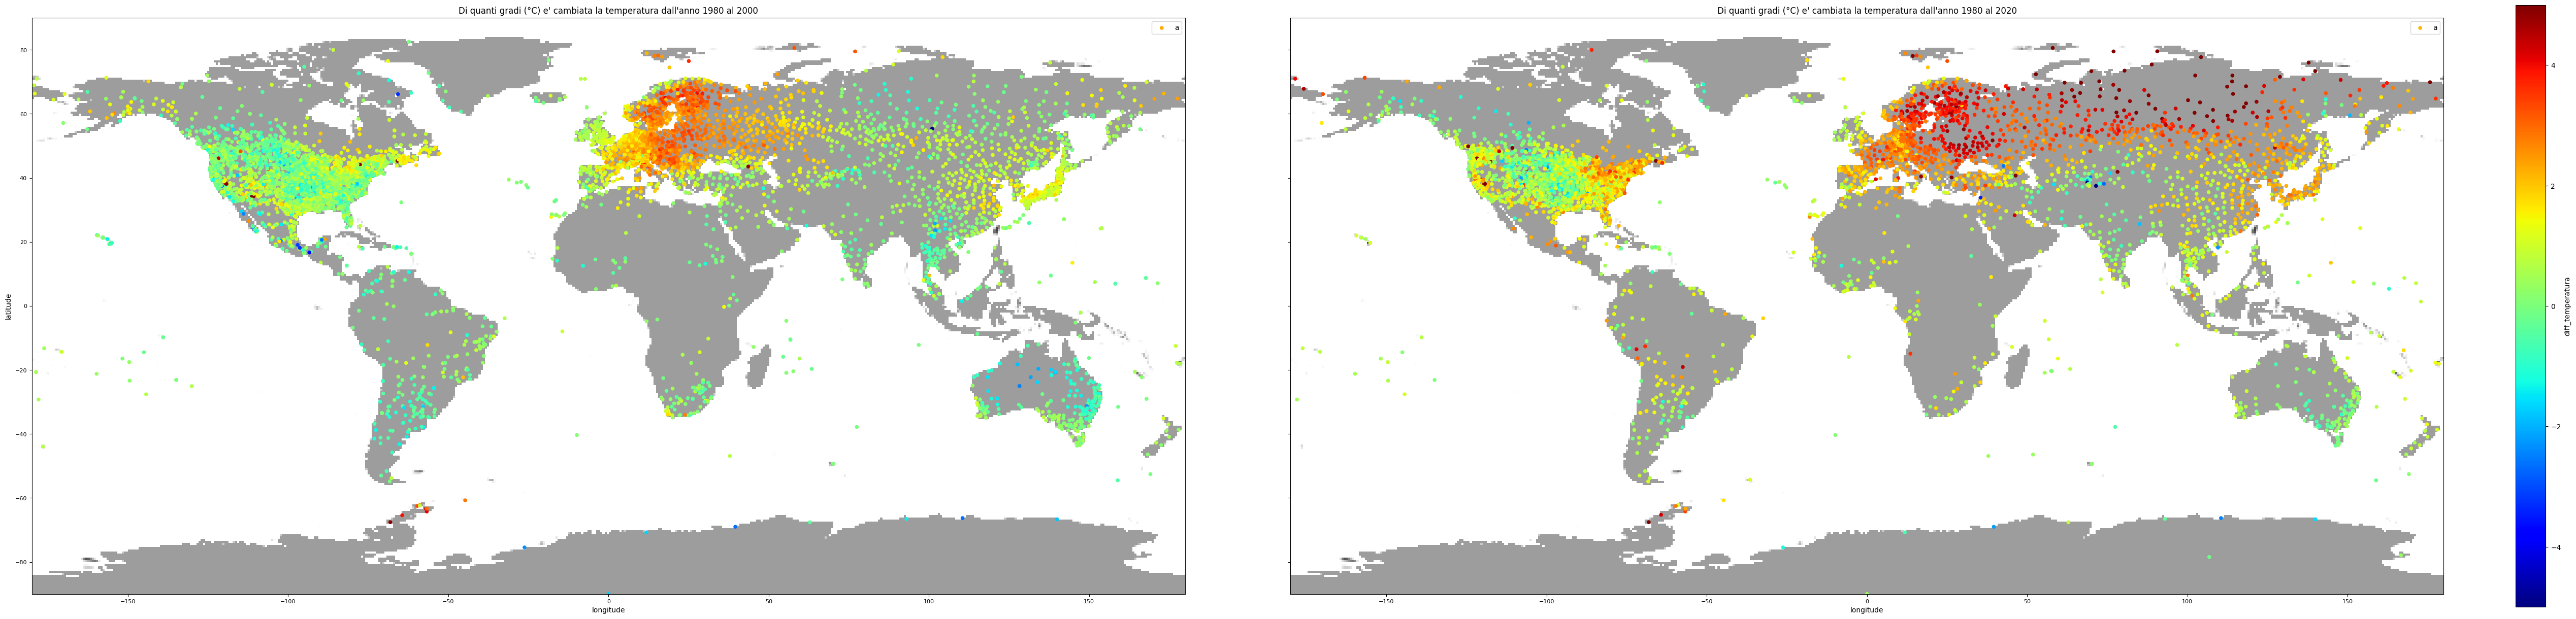

In [42]:
def plot_map_difference_temperatures(list_years):
    """ Funzione che disegna i grafici con le differenze di temperature degli anni dati in input."""
    def plot_map_two_years(year1, year2, i):
        def get_col_name(year):
            return 'temperatura_year_'+str(year)
        
        def get_df(anno):
            """Questa funzione ritorna un DataFrame contenente le rilevazioni delle temperature dell'anno dato in input.
            Il dataframe in output ha i seguenti campi:
                station_id, latitude, longitude -> informazioni delle stazioni
                year -> anno in input
                temperatura_year_anno -> temperatura media dell'anno 'anno' in input
            """
            df_to_plot = df_temperatures[(df_temperatures["year"] == anno)]    # Seleziono solo l'anno desiderato
            df_to_plot = df_to_plot.merge(df_stations, on="station_id")        # Faccio il merge con le stazioni
            df_to_plot = df_to_plot.rename(columns={"temp_media":get_col_name(anno) }) # Rinomino la colonna 
            df_to_plot = df_to_plot[["station_id", "year","latitude", "longitude", get_col_name(anno)]] # Seleziono solo alcuni campi
            return df_to_plot   
    
        # Faccio il merge dei due dataframe dei due anni in input, in base alla station_id
        df = get_df(year1).merge(get_df(year2), how="inner",  on=["station_id", "latitude", "longitude"])

        # Calcolo la differenza della temperatura media annuale
        df['diff_temperatura'] = df[get_col_name(year2)] - df[get_col_name(year1)]
        
        # Setto gli estremi della latitudine e la longitudine, in modo da far combaciare la cartina geografica in background
        ylim=(-90,90)#(df["latitude"].min(), df["latitude"].max())
        xlim=(-180,180)#(df["longitude"].min(), df["longitude"].max())

        # Disegno il grafico
        titolo = "Di quanti gradi (°C) e' cambiata la temperatura dall'anno "+str(year1)+" al " + str(year2)
        grafico = df.plot(x="longitude", y="latitude", label="a",c="diff_temperatura",fontsize=8, ylim=ylim, xlim=xlim, \
            clim=(-5,5),kind="scatter", colormap="jet", title=titolo, ax=axes[i], figsize=(54,27))#, figsize=(20, 10))
        
        # TODO da cambiare path ed eventualemnte foto
        img = plt.imread("applicazione/data/imgs/world3_new.png")
        grafico.imshow(img, extent=[xlim[0], xlim[1], ylim[0], ylim[1]])

    
    fig, axes = plt.subplots(nrows=1,ncols=len(list_years)-1, sharey=True, figsize=(2,2))

   
    i=0
    for anno2 in list_years[1:]:
        plot_map_two_years(list_years[0], anno2, i)
        i += 1
    
    # Abbellimenti del grafico: lascio solo l'ultima colorbar, tolgo lo spazio tra i grafici, setto l'altezza finale
    f = plt.gcf()
    j = 0
    for i in f.get_axes():
        if i._label == "<colorbar>":
            if j != len(list_years)-2:
                i.remove()
            j += 1
    fig.tight_layout()
    fig.set_figheight(12)

    plt.show()


# Disegno le mappe
print("Nel grafico a sinistra si può osservare di quanti gradi (°C) è aumentata la temperatura tra gli anni 1980 e 2000.\nIn quello a destra tra il 1980 e il 2020.")
plot_map_difference_temperatures([1980,2000,2020])#, 2020])

<mark>
Considerazioni: si può notare che la temperatura è in aumento + discorso sui continenti mancanti

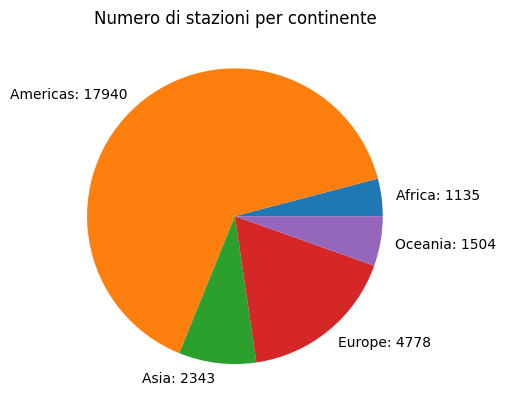

In [43]:
# Conto quante stazioni ci sono per continente
df_stations_per_continent = df_stations.merge(df_country, on="fips")
df_stations_per_continent = df_stations_per_continent.groupby("region").count()["station_id"]
labels = [region + ": " + str(n_stazioni) for region, n_stazioni in df_stations_per_continent.items()]

# Stampo il grafico
pie = df_stations_per_continent.plot(kind="pie", title="Numero di stazioni per continente", labels=labels, label="")

Come si può notare, ci sono molte piu' stazioni in America e in Europa rispetto all'Africa, ...

<mark> Da fare o da togliere
Di quanti gradi (°C) si è alzata la temperatura dal 1960 ad oggi?
- Calcolare la temperatura media annuale di ogni anno di ogni stazione
- Prendere 5 stazioni (1 per ogni continente) e 2 anni per stazione. La stazione e gli anni devono essere prese in modo da far vedere la massima differenza di temperatura registrata.
- Fare 5 subplot facendo vedere i cambiamenti


### In quali anni e in quali stazioni è stata registrata la maggiore differenza di temperatura?
L'output è in gradi °C

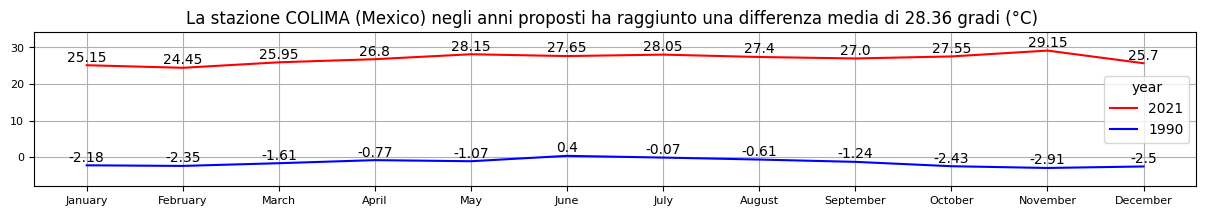

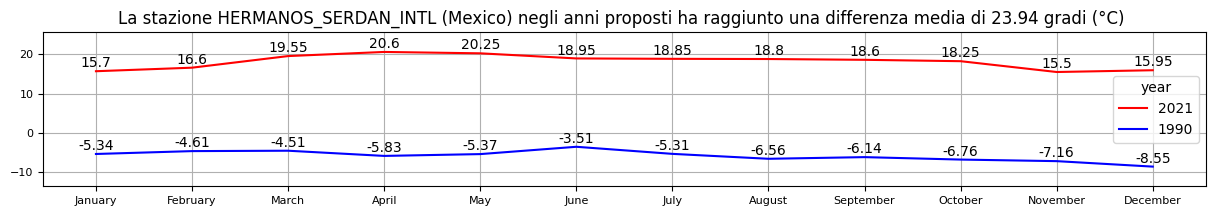

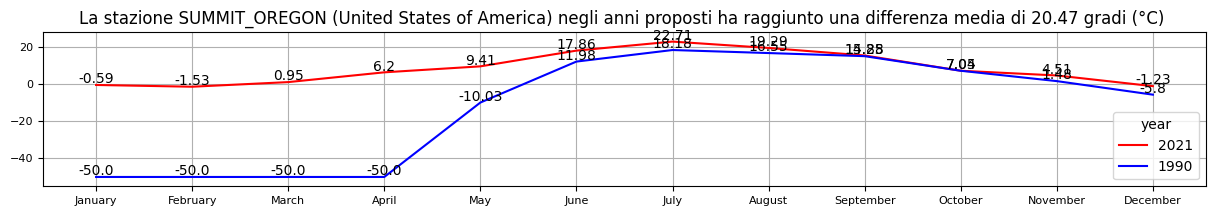

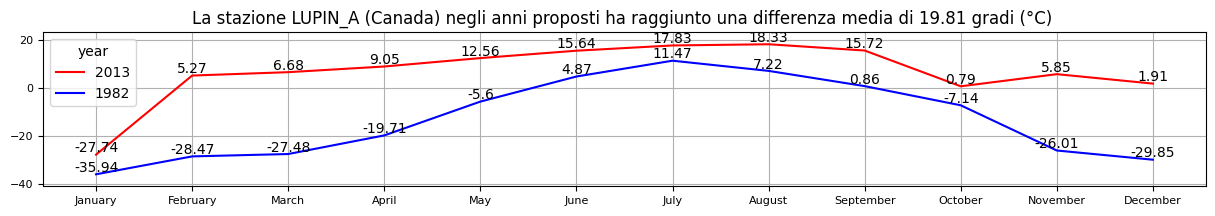

In [44]:
# Numero di grafici da mostrare
N = 4

# Calcolo la temperatura media annuale di ogni record
df = df_temperatures.copy()
df["temp_media"] = df_temperatures[[calendar.month_name[i]+"_value" for i in range(1,13)]].mean(axis=1)    
df = df[["station_id", "year", "temp_media"]]

# Per ogni stazione, seleziono due record: quello con l'anno minimo e quello con l'anno massimo
df_min = df.sort_values("year").groupby("station_id", as_index=False).first()
df_max = df.sort_values("year", ascending=False).groupby("station_id", as_index=False).first()
df = pd.concat([df_min, df_max]).sort_values(by=["station_id", "year"])

# Per ogni record rimasto, calcolo la differenza di temperatura media tra l'anno massimo e quello minimo
df["diff"] = df.groupby(['station_id'])['temp_media'].diff()

# Ordino i record in base alla differenza (decrescente) appena calcolata. Seleziono solo i primi N record
df_first_n_record = df.sort_values(by="diff", ascending=False).head(N)

# In df_first_n_record saranno present solo  record con gli anni massimi. Aggiungo quelli con gli anni minimi
df_tmp = df_first_n_record
for _, record in df_first_n_record.iterrows():
    record2 = df[(df["station_id"] == record["station_id"]) & (pd.isna(df["diff"]))]
    df_tmp = pd.concat([df_tmp, record2])

# Faccio il merge con i dati delle stazioni e dei paesi
df = df_tmp.merge(df_stations, on="station_id").merge(df_country, on="fips").merge(df_temperatures, on=["station_id", "year"])

# Per ogni stazione, stampo un grafico
for _, record in df_first_n_record.iterrows():
    # Seleziono i due record della stazione
    df_station_to_plot = df[df["station_id"] == record["station_id"]]

    nome_stazione = df_station_to_plot.iloc[1]["station_name"] 
    nome_country = df_station_to_plot.iloc[1]["name_country"] 
    titolo = "La stazione "+ nome_stazione  +" ("+ nome_country  \
        + ") negli anni proposti ha raggiunto una differenza media di " + f"{df_station_to_plot['diff'].max():.2f}" + " gradi (°C) "

    # Imposto l'anno come indice. Tengo solo le colonne con le temperature. Cambio i nomi alle colonne
    df_station_to_plot = df_station_to_plot.set_index(["year"])
    df_station_to_plot = df_station_to_plot[[calendar.month_name[i]+"_value" for i in range(1,13)]]                         
    df_station_to_plot = df_station_to_plot.rename(columns={calendar.month_name[i]+"_value":calendar.month_name[i] for i in range(1,13)})

    # Disegno il grafico, con la griglia in background
    y_min = df_station_to_plot.min().min()
    y_max = df_station_to_plot.max().max()
    df_station_to_plot.transpose().plot(figsize=(15,2), fontsize=8, title=titolo, color=['red', 'blue'], ylim=(y_min-5, y_max+5), xticks=[i for i in range(12)])
    plt.grid(True)
    for i in range(1,13):
        # if i % 2 == 1:
        for _, temp in df_station_to_plot.iterrows():
            plt.text(i-1, temp[calendar.month_name[i]]+1, temp[calendar.month_name[i]], ha='center' )


Mettere qualcosa del tipo: negli ultimi secoli si sono monitorate di piu' le temperature ... -> per introdurre il prossimo grafico
oppure
Fare un grafico come quello dei livelli del mare, dicendo tipo "per non sfasare troppo i dati, inizio a calcolare i dati da un anno in cui sono state monitorate abbastanza stazioni" 
Prendiamo, ad esempio il 1960.

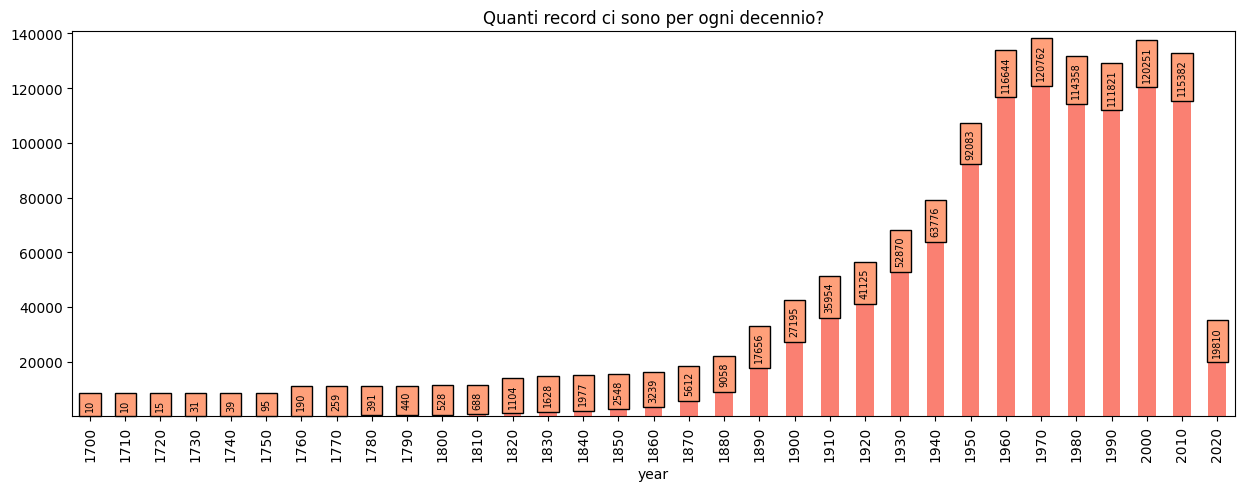

In [45]:
# Quanti dati ci sono per decennio?

# Raggruppo i dati per anno e poi per decennio
df_record_per_year = df_temperatures.groupby("year").count()["station_id"].sort_values().transpose()
df_record_per_year = df_record_per_year.groupby((df_record_per_year.index//10)*10).sum()

# Disegno il grafico 
tmp = df_record_per_year.plot(kind="bar", figsize=(15,5), title="Quanti record ci sono per ogni decennio?", \
    color="salmon", ylim=(df_record_per_year.values.min(), 20000+df_record_per_year.values.max()))
y_val = df_record_per_year.values
for i in range(len(y_val)):
    plt.text(i, y_val[i]+2800, y_val[i], ha = 'center', bbox = dict(facecolor = 'lightsalmon', alpha=1),rotation="vertical", fontsize="x-small")


### I livelli dei mari si stanno alzando?

In [46]:

def get_min_max_years_values_in_df(df):
    min_year = df.index.min()
    min_value = df[df.index == min_year][df.columns[0]].item() 
    min_value = round(min_value, 2)

    max_year = df.index.max()
    max_value = df[df.index == max_year][df.columns[0]].item()
    max_value = round(max_value, 2)
    
    return [min_year, min_value, max_year, max_value]
# min_year, min_value, max_year, max_value = get_min_max_years_values_in_df(df)

def print_tag_in_grafico(x, y, text):
    plt.text(x, y,text, fontweight="bold", fontsize="medium", color='red', ha="center")



Dal 1993 al 2021 i livelli del mare si sono alzati di 84.64 mm. Per una media di 3.02 mm all'anno.


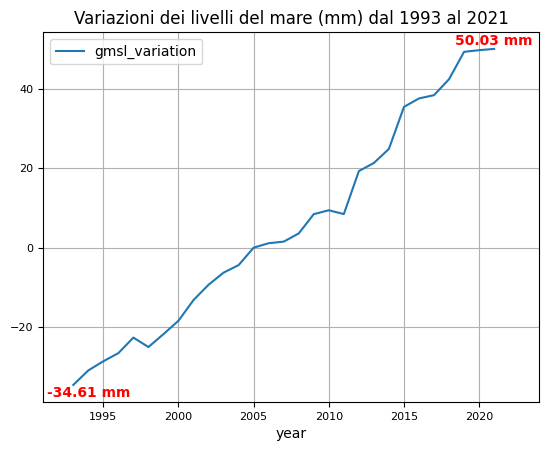

In [47]:
# Salvo le variazioni del primo e dell'ultimo anno
df_sea_to_print = df_sea.iloc[[0, -1]]
min_year, min_value, max_year, max_value = get_min_max_years_values_in_df(df_sea_to_print)

# Disegno il grafico
titolo = "Variazioni dei livelli del mare (mm) dal "+ str(min_year) + " al " + str(max_year)
df_sea.plot(fontsize=8, title=titolo, xlim=(min_year-2, max_year+3))
plt.grid(True)
print_tag_in_grafico(min_year+1, min_value-3, str(min_value)+" mm")
print_tag_in_grafico(max_year, max_value+1,str(max_value)+" mm")

# Stampo la differenza totale e media
differenza_totale = max_value - min_value   # differenza_totale = df_sea.iloc[[0, -1]].diff().dropna()['gmsl_variation'].item()
media = differenza_totale / (max_year-min_year)
print("Dal",min_year ,"al", max_year, "i livelli del mare si sono alzati di", f"{differenza_totale:.2f}","mm. Per una media di", f"{media:.2f}", "mm all'anno.")

Dal 1980 al 2021 la temperatura media globale si è alzata di 1.04°C. Per una media di 0.03°C all'anno.


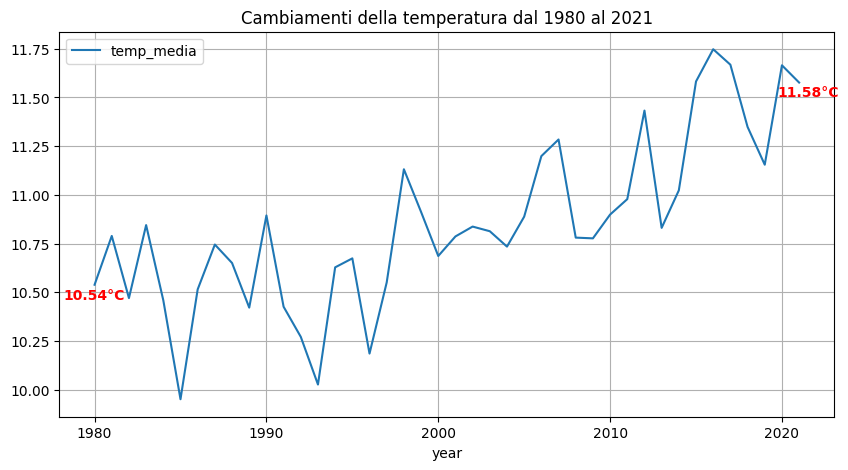

In [48]:
MIN_YEAR = 1980

# df_temp_media = df_temperatures.merge(df_stations).merge(df_country)
def get_df_temp_media_globale_per_anno(min_year=MIN_YEAR):
    """Questa funzione ritorna un DataFrame con
        - indice su 'year'
        - un campo 'temp_media' contenente la temperatura media globale registrata nel relativo anno. 
    """
    df_temp_media = df_temperatures[["station_id", "year", "temp_media"]]
    df_temp_media = df_temp_media[(df_temp_media["year"] >= min_year) ]#&  (df_temp_media["year"] <= 2010)]
    df_temp_media = df_temp_media.groupby("year").mean(numeric_only=True)
    return df_temp_media

# Calcolo la temperatura media globale. Ne memorizzo i valori nell'anno massimo e minimo 
df_temp_media = get_df_temp_media_globale_per_anno()
min_year, min_value, max_year, max_value = get_min_max_years_values_in_df(df_temp_media)


# Disegno il grafico
df_temp_media.plot(figsize=(10,5), title="Cambiamenti della temperatura dal " + str(MIN_YEAR) + " al " + str(max_year))#, xticks=[i for i in range(MIN_YEAR-1, max_year+2)])
plt.grid()
print_tag_in_grafico(MIN_YEAR, min_value-0.075, f"{min_value:.2f}°C")#, ha='center', fontweight="bold", fontsize="medium", color='red')
print_tag_in_grafico(max_year+0.5, max_value-0.075, f"{max_value:.2f}°C")#, ha='center', fontweight="bold", fontsize="medium", color='red')

# Stampo la differenza di temperatura totale e media
df_temp_media = df_temp_media.iloc[[0, -1]]
differenza_totale = df_temp_media.diff().dropna()['temp_media'].item()
media = differenza_totale / (max_year-MIN_YEAR)
print("Dal",MIN_YEAR ,"al", max_year, "la temperatura media globale si è alzata di", f"{differenza_totale:.2f}","\b°C. Per una media di", f"{media:.2f}", "\b°C all'anno.")

Dire che anche se 1 grado sembra poco, in realtà è tanto

## 4. Correlazione tra temperature in aumento e co2 e innalzamento dei livelli del mare

In [49]:
# TODO Stampare i livelli di CO2

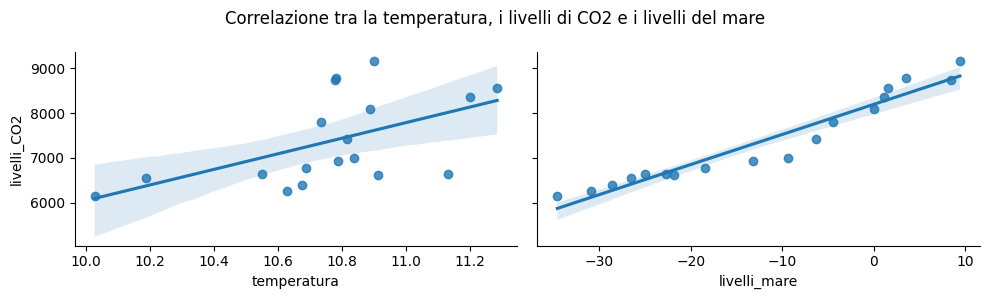

In [50]:
# Calcolo la temperatura media globale per ogni anno
df_temp_media = get_df_temp_media_globale_per_anno()

# Unisco i tre dataframe e cambio i nomi delle colonne
df_correlazione = df_temp_media.merge(df_co2, left_index=True, right_index=True).merge(df_sea, left_index=True, right_index=True)
df_correlazione = df_correlazione.rename(columns={"temp_media":"temperatura", "gmsl_variation":"livelli_mare", "co2_level":"livelli_CO2" })
# df_correlazione = df_correlazione[(df_correlazione.index == 1993) | (df_correlazione.index == 2000)]

# Disegno i grafici
map_correlazione = sns.PairGrid(df_correlazione, y_vars=["livelli_CO2"],  x_vars=["temperatura", "livelli_mare"])
map_correlazione.fig.set_size_inches(10, 3)
map_correlazione.map(sns.regplot)
map_correlazione.fig.suptitle('Correlazione tra la temperatura, i livelli di CO2 e i livelli del mare', fontsize=12)
plt.tight_layout()
plt.show()

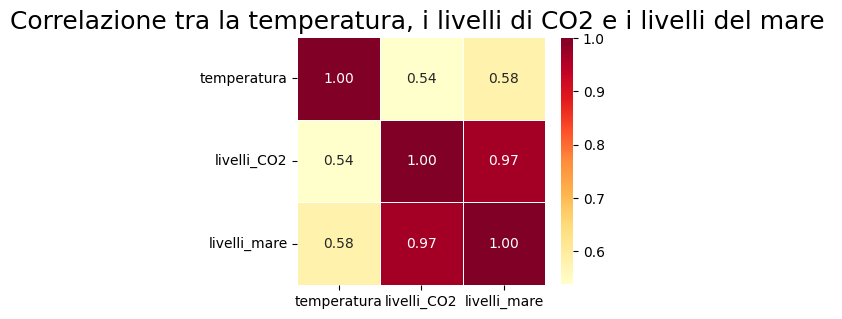

In [51]:
# Calcolo la correlazione...
df_corr =  df_correlazione.corr()

# ... e ne disegno la matrice
plt.figure(figsize=(4,4))
sns.heatmap(df_corr, square=True, fmt='.2f', linewidths=.5, cmap="YlOrRd", annot=True, cbar_kws={"shrink": 0.8})
plt.yticks(rotation=0)
plt.title("Correlazione tra la temperatura, i livelli di CO2 e i livelli del mare ", fontsize=18)
plt.show()

Conclusioni sulla correlazione...

## 5. Andamenti futuri
Perchè è importante fermare i cambiamenti climatici?
Se non li fermassimo, ecco come sarebbe la situazione in futuro:

In [52]:
import numpy as np
from sklearn import linear_model

def predict_df_futuro(df_presente):
    # Salvo i valori gia' presenti
    nome_colonna = df_presente.columns[0]
    valori_presenti = np.array(df_presente[nome_colonna])
    years_presenti =  np.array(df_presente.index)

    # Calcolo i valori futuri
    years_futuri = np.arange(2022, 2100, 10) # numpy.ndarray con futuri anni
    
    line = linear_model.LinearRegression()
    line.fit(years_presenti.reshape(-1,1), valori_presenti)
    valori_futuri = line.predict(years_futuri.reshape(-1,1))   # numpy.ndarray con futuri valori

    # Calcolo e ritorno il datafram
    df_futuro = pd.DataFrame({nome_colonna: valori_futuri, 'year': list(years_futuri)}, columns=[nome_colonna, 'year'])
    df_futuro = df_futuro.set_index('year')
    return df_futuro

year,2022,2032,2042,2052,2062,2072,2082,2092
temp_media,11.430696,11.699951,11.969206,12.238461,12.507716,12.776971,13.046226,13.315481


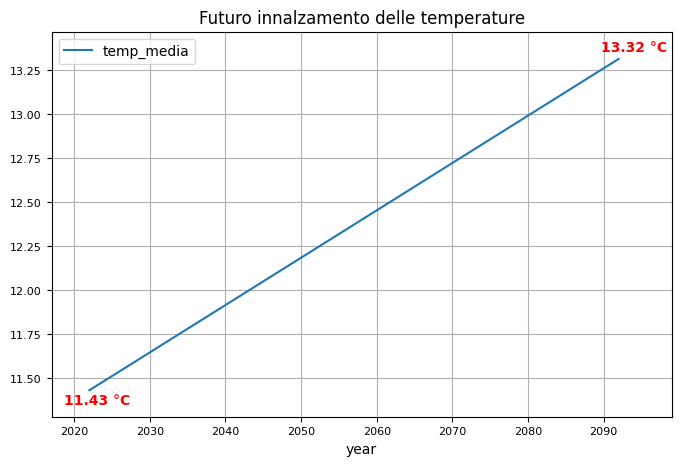

In [53]:
# Calcolo e stampo un Dataframe per l'andamento futuro delle temperature
df_temp_media = get_df_temp_media_globale_per_anno()
df_futuro = predict_df_futuro(df_temp_media)
display(df_futuro.transpose())

# Disegno il grafico
titolo = "Futuro innalzamento delle temperature"
min_year, min_value, max_year, max_value = get_min_max_years_values_in_df(df_futuro)
df_futuro.plot(fontsize=8, figsize=(8,5), title=titolo, xlim=(min_year-5, max_year+7), ylim=(min_value-0.15, max_value+0.15))
print_tag_in_grafico(min_year+1, min_value-0.08, str(min_value)+" °C")
print_tag_in_grafico(max_year+2, max_value+0.04,str(max_value)+" °C")
plt.grid(True)

year,2022,2032,2042,2052,2062,2072,2082,2092
gmsl_variation,52.259437,83.456731,114.654025,145.851319,177.048612,208.245906,239.4432,270.640494


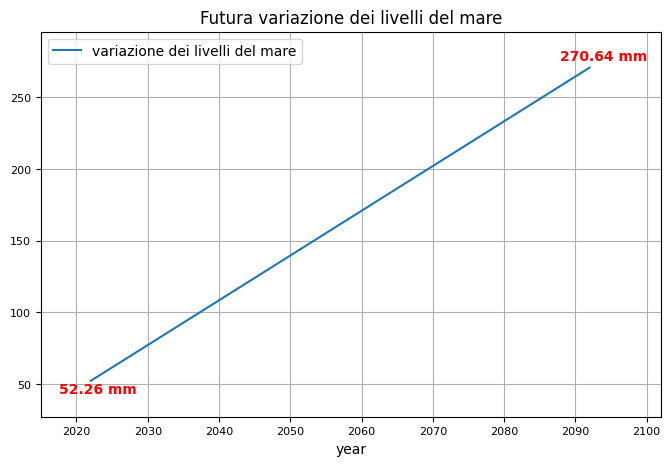

In [54]:
# Calcolo e stampo un Dataframe per l'andamento futuro dei livelli del mare
df_futuro = predict_df_futuro(df_sea)
display(df_futuro.transpose())

# Disegno il grafico
titolo = "Futura variazione dei livelli del mare"
min_year, min_value, max_year, max_value = get_min_max_years_values_in_df(df_futuro)
df_futuro.plot(fontsize=8, figsize=(8,5), title=titolo, xlim=(min_year-7, max_year+10), ylim=(min_value-25, max_value+25))
print_tag_in_grafico(min_year+1, min_value-9, str(min_value)+" mm")
print_tag_in_grafico(max_year+2, max_value+5,str(max_value)+" mm")
plt.grid(True)
plt.legend(loc='upper left').get_texts()[0].set_text("variazione dei livelli del mare")

## 6. Conclusioni
